In [ ]:
'''
Predict house prices with kernel regression
'''

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [ ]:
# Read data
train = pd.read_csv("train.csv") 
test = pd.read_csv("test.csv") 

# Data Cleaning

In [ ]:
# Copy 
Train = train.copy()
Test = test.copy()
# Find columns with missing values and their percent missing
Train.isnull().sum()                                                     
miss_val = Train.isnull().sum().sort_values(ascending=False)
miss_val = pd.DataFrame(data=Train.isnull().sum().sort_values(ascending=False), columns=['MissvalCount'])
# Add a new column to the dataframe and fill it with the percentage of missing values
miss_val['Percent'] = miss_val.MissvalCount.apply(lambda x : '{:.2f}'.format(float(x)/Train.shape[0] * 100)) 
miss_val = miss_val[miss_val.MissvalCount > 0]
miss_val

,MissvalCount,Percent
PoolQC,1453,99.52
MiscFeature,1406,96.30
Alley,1369,93.77
Fence,1179,80.75
FireplaceQu,690,47.26
LotFrontage,259,17.74
GarageCond,81,5.55
GarageType,81,5.55
GarageYrBlt,81,5.55
GarageFinish,81,5.55


We'll remove those features with a high percent of missing values such as PoolQC, MiscFeature, Alley, Fence, and FireplaceQu.

In [ ]:
# Drop columns with high missing values
Train.drop(["Id","Alley","FireplaceQu","PoolQC","Fence","MiscFeature"], axis = 1, inplace=True)
Test.drop(["Id","Alley","FireplaceQu","PoolQC","Fence","MiscFeature"], axis = 1, inplace=True)

In [ ]:
# Handling null values
# Get the sum of all na values from dataset
Train.isna().sum()

MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
Street             0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 75, dtype: int64

Since null values as comapre to total training examples is verry less we can safly drop those examples

In [ ]:
Train.dropna(inplace=True)
# Check the dimension of the dataset
Train.shape

(1094, 75)

In [ ]:
# Seperating examples and labels from the training dataset
X =  Train.drop(['SalePrice'], axis=1)
y = Train.SalePrice

In [ ]:
# One hot encoding
X = pd.get_dummies(X)
Test = pd.get_dummies(Test)
# Get common coloumns of train & test data
common_cols = [i for i in list(Train) for j in list(Test) if i==j]
Train_common = X[common_cols]
Test_common = Test[common_cols]

In [ ]:
# Noramalization of Data
def normalize(data):
  normalize_data = data.copy()
  mean = normalize_data.mean(axis = 0)
  std = normalize_data.std(axis = 0)
  normalize_data -= mean
  normalize_data /= std
  return normalize_data
  
Train_normalize = normalize(Train_common)
Test_normalize = normalize(Test_common)

In [ ]:
Train_clean = Train_normalize.fillna(0)
Test_clean = Test_normalize.fillna(0)

In [ ]:
Train_clean.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,0.092221,-0.235001,-0.204858,0.550400,-0.539961,0.980699,0.816219,0.451805,0.550016,-0.284471,-1.023063,-0.585693,-0.819779,1.132503,-0.111188,0.332569,1.121593,-0.240911,0.767519,1.219274,0.180637,-0.181988,0.902259,-0.964438,0.942152,0.183208,0.230101,-0.769355,0.216801,-0.358175,-0.11016,-0.282236,-0.073866,-0.140906,-1.608971,0.160303
1,-0.860696,0.377023,-0.064823,-0.181238,2.272978,0.115030,-0.473748,-0.576163,1.130310,-0.284471,-0.722503,0.390617,0.227483,-0.811675,-0.111188,-0.518941,-0.822976,4.009996,0.767519,-0.777561,0.180637,-0.181988,-0.359980,0.615046,-0.098935,0.183208,-0.227610,1.660826,-0.724267,-0.358175,-0.11016,-0.282236,-0.073866,-0.140906,-0.495616,-0.589149
2,0.092221,-0.112596,0.136096,0.550400,-0.539961,0.916575,0.768443,0.273484,0.080661,-0.284471,-0.386056,-0.431792,-0.654693,1.159822,-0.111188,0.477022,1.121593,-0.240911,0.767519,1.219274,0.180637,-0.181988,-0.359980,0.615046,0.865034,0.183208,0.542176,-0.769355,-0.076319,-0.358175,-0.11016,-0.282236,-0.073866,-0.140906,0.988857,0.160303
3,0.330451,-0.439009,-0.070912,0.550400,-0.539961,-1.840741,-0.760407,-0.576163,-0.495366,-0.284471,-0.148299,-0.826164,-0.548935,0.909401,-0.111188,0.345874,1.121593,-0.240911,-1.049939,-0.777561,0.180637,-0.181988,0.271139,0.615046,0.749358,1.701612,0.719019,-0.769355,-0.184310,4.059525,-0.11016,-0.282236,-0.073866,-0.140906,-1.608971,-1.338602
4,0.092221,0.540229,0.502622,1.282038,-0.539961,0.884513,0.672889,1.259493,0.441211,-0.284471,-0.260449,0.109267,-0.074314,1.585538,-0.111188,1.260107,1.121593,-0.240911,0.767519,1.219274,1.489354,-0.181988,1.533378,0.615046,0.826476,1.701612,1.728062,0.796399,0.571629,-0.358175,-0.11016,-0.282236,-0.073866,-0.140906,2.102212,0.160303


The dataset is cleaned.

# Explore data

Let's examine the data distributions of the features. We will start with the target variable, SalesPrice, to make sure it's normal distributed.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



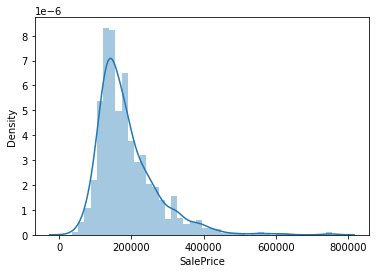

In [ ]:
# Check distribution of target variable
sns.distplot(y)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



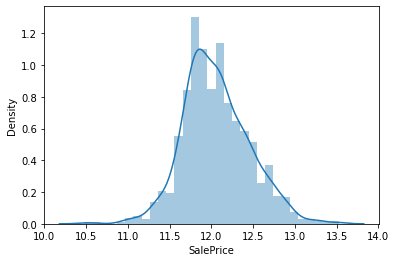

In [ ]:
# Transform the target variable 
sns.distplot(np.log(y))

The data is now more normal distributed. We will use this transformed data in the dataframe

In [ ]:
y_log = np.log(y)

# Train-Test Split dataset

Before we can start modeling the data, we need to split the dataset into training and test sets. We will train the models with the training set and cross-validate with the test set.

To split the dataset, we will use random sampling with 85/15 train-test split; that is, we'll use 85% of the dataset for training and set aside 15% for testing:

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Train_clean, y, test_size = 0.15, random_state = 3)

# Compute RMSE

Define a function for computing rmse of model.

In [ ]:
def rmse(predictions, targets):
    return np.sqrt(np.mean(np.square(predictions - targets)))

# Box Kernel Regression

Define a class for Box kernel Regression

In [ ]:
class BKR:
    
    def __init__(self, x, y, h):
        self.x = np.array(x)
        self.y = np.array(y)
        self.h = h
    
    # Implement the Box Kernel
    def box_kernel(self, z, h):
        return (z <= h) * 1
        
    # Calculate weights and return prediction
    def get_predict(self, X):
        kernels = np.array([self.box_kernel((np.linalg.norm(xi - X)), self.h) for xi in self.x])
        kernel_sum = np.sum(kernels)
        if kernel_sum == 0:
            return 0
        else:
            weights = np.array([len(self.x) * (kernel/kernel_sum) for kernel in kernels])
            return np.dot(weights.T, self.y)/len(self.x)

In [ ]:
# Get the optimal h
h_list = np.arange(5,10,0.4)
BKR_RMSE = []
for h in h_list:
    model = BKR(X_train, y_train, h)
    y_hat = []
    for i in np.array(X_test):
        single_y = BKR.get_predict(model, i)
        y_hat.append(single_y)
    BKR_RMSE.append([h, rmse(y_hat, y_test)])

print(pd.DataFrame({'h value':np.array(BKR_RMSE)[:,0], 'rmse':np.array(BKR_RMSE)[:,1]}))


    h value          rmse
0       5.0  85464.748672
1       5.4  72837.071951
2       5.8  63628.288331
3       6.2  65206.331600
4       6.6  40235.571574
5       7.0  40825.559082
6       7.4  43881.638375
7       7.8  45260.478109
8       8.2  50646.704431
9       8.6  53947.588562
10      9.0  57432.312229
11      9.4  60485.679319
12      9.8  63743.354528


In [ ]:
# Best RMSE 
# h = 6.6
print(f"Best RMSE is {min(np.array(BKR_RMSE)[:,1])}")

Best RMSE is 40235.57157397084


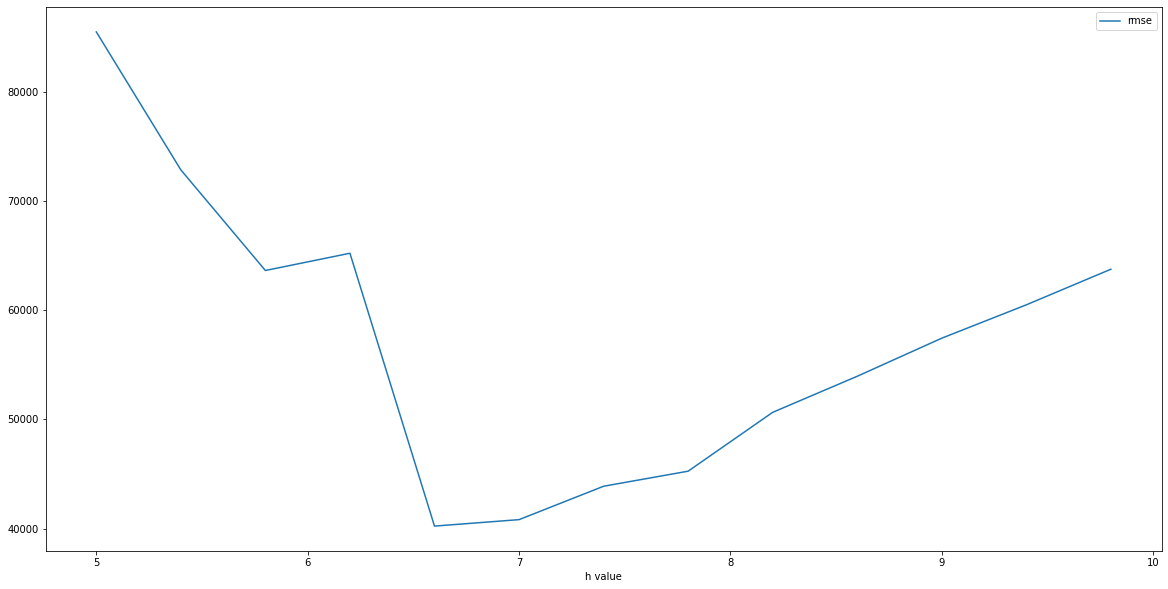

In [ ]:
# Visualize impact of h
df = pd.DataFrame({'h value':np.array(BKR_RMSE)[:,0], 'rmse':np.array(BKR_RMSE)[:,1]}) 
df.plot(kind='line', x="h value", y="rmse", figsize=(20,10)) 
plt.show()

In [ ]:
# Predict on test set

# Build model with optimal h
model_BKR = BKR(X_train, y_train, 6.6)
# Train model
y_hat_train = []
for i in np.array(X_test):
    single_y = BKR.get_predict(model_BKR, i)
    y_hat_train.append(single_y)

# Predict test data
y_hat_test = []
for i in np.array(Test_clean):
    single_y = BKR.get_predict(model_BKR, i)
    y_hat_test.append(single_y)

y_hat_test

[141622.09210526315,
 0,
 183494.19017094022,
 192247.20770877946,
 182079.71485943772,
 185279.12291666667,
 185597.45360824742,
 181300.5813492063,
 186311.0920770878,
 148628.18393782384,
 193735.6573033708,
 136724.91578947369,
 144363.69798657717,
 169026.1323529412,
 144837.98205128207,
 259958.78947368418,
 228928.8064516129,
 252472.4175824176,
 241397.2192513369,
 432966.8571428571,
 247276.04620462048,
 201160.57230769232,
 190271.7508305648,
 183788.3680781759,
 184055.2829736211,
 195575.98122065724,
 269382.99999999994,
 228840.6106557377,
 193492.7987220447,
 220125.8014184397,
 198084.66987951807,
 129304.63580246911,
 192796.15384615384,
 265678.5714285714,
 235802.96428571432,
 201162.90808823527,
 184284.32163742688,
 179487.30964467005,
 178973.96951219512,
 178270.22282608695,
 200477.27272727274,
 173053.37404580152,
 394617.0,
 216456.78796561604,
 210529.391521197,
 199835.15570934257,
 230964.25570776252,
 196209.07228915664,
 170566.2188449848,
 165389.33243967

# Gaussian kernel Regression

Define a class for Gaussian kernel Regression

In [ ]:
class GKR:
    
    def __init__(self, x, y, sigma):
        self.x = np.array(x)
        self.y = np.array(y)
        self.sigma = sigma
    
    # Implement the Gaussian Kernel
    def gaussian_kernel(self, z):
        return (1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * z ** 2)
    
    # Calculate weights and return prediction
    def get_predict(self, X):
        kernels = np.array([self.gaussian_kernel((np.linalg.norm(xi - X)) / self.sigma) for xi in self.x])
        weights = np.array([len(self.x) * (kernel / np.sum(kernels)) for kernel in kernels])
        return np.dot(weights.T, self.y)/len(self.x)

In [ ]:
# Get the optimal sigma
h_list=np.arange(1,2,0.1)
GKR_RMSE = []
for h in h_list:
    model = GKR(X_train, y_train, h)
    y_hat = []
    for i in np.array(X_test):
        single_y = GKR.get_predict(model, i)
        y_hat.append(single_y)
    GKR_RMSE.append([h, rmse(y_test, y_hat)])

print(pd.DataFrame({'sigma value':np.array(GKR_RMSE)[:,0], 'rmse':np.array(GKR_RMSE)[:,1]}))

   sigma value          rmse
0          1.0  25458.798292
1          1.1  24707.841594
2          1.2  24138.680070
3          1.3  23860.600230
4          1.4  23978.113286
5          1.5  24538.493563
6          1.6  25503.330911
7          1.7  26780.329755
8          1.8  28272.789426
9          1.9  29905.739394


In [ ]:
# Best RMSE 
# sigma = 1.3
print(f"Best RMSE is {min(np.array(GKR_RMSE)[:,1])}")

Best RMSE is 23860.600229859447


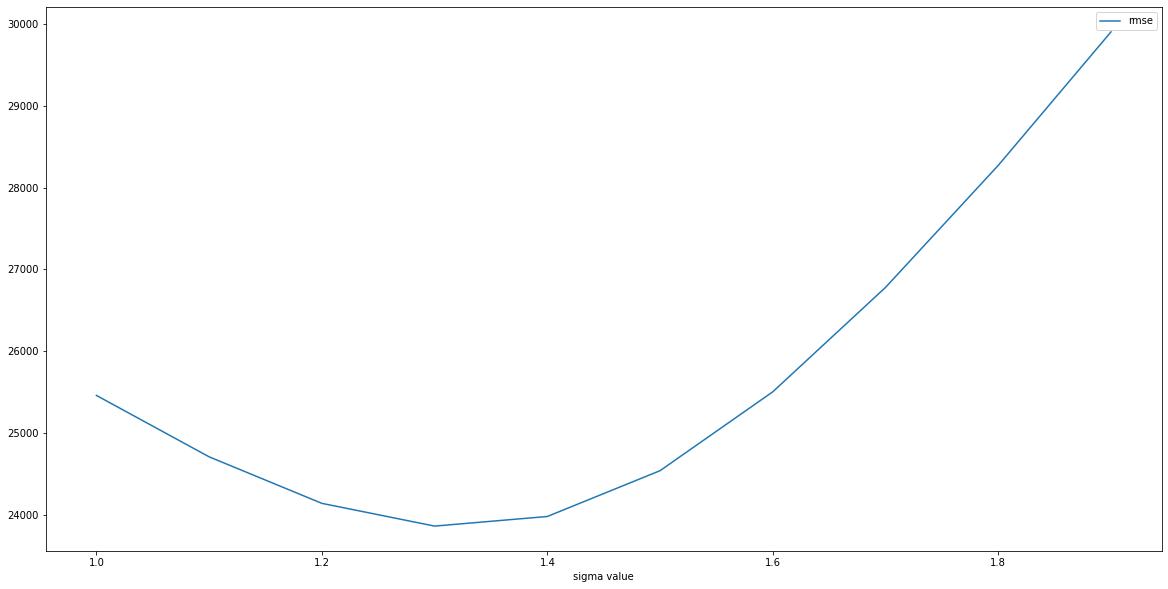

In [ ]:
# Visualize impact of sigma
df = pd.DataFrame({'sigma value':np.array(GKR_RMSE)[:,0], 'rmse':np.array(GKR_RMSE)[:,1]}) 
df.plot(kind='line', x="sigma value", y="rmse", figsize=(20,10)) 
plt.show()

In [ ]:
# Predict on test set

# Build model with optimal sigma
model_GKR = GKR(X_train, y_train, 1.3)
# Train model
y_hat_train = []
for i in np.array(X_test):
    single_y = GKR.get_predict(model_GKR, i)
    y_hat_train.append(single_y)

# Predict test data
y_hat_test = []
for i in np.array(Test_clean):
    single_y = GKR.get_predict(model_GKR, i)
    y_hat_test.append(single_y)

y_hat_test

[122160.72011121549,
 266350.6395825696,
 201138.22909697366,
 200659.14999541093,
 168641.50915347235,
 194101.19538223863,
 184630.21306525182,
 189192.272641629,
 178622.41696709362,
 128256.13443147797,
 224801.2613184241,
 101203.47220837552,
 99806.74293287231,
 147839.2196027385,
 119154.23798574961,
 299922.0185587494,
 234295.33639518332,
 265316.4920529622,
 276918.30168032553,
 499101.1853685046,
 319312.4716381271,
 193118.16873799948,
 190338.9562440298,
 182605.92298226693,
 197812.5501849347,
 195699.51443300568,
 294945.1274679516,
 239041.03449788972,
 202600.46089226214,
 230040.0020873797,
 201613.85134020622,
 102012.00962719039,
 153263.0349935469,
 247510.99750709176,
 288607.98399694025,
 222952.39353029308,
 164888.08089050523,
 161707.63762347167,
 160695.50898180404,
 162546.53924108663,
 179476.8494108766,
 168551.50224755032,
 388214.5093887717,
 226493.3387335147,
 225370.3419764569,
 201450.2692016011,
 263070.535722258,
 174626.01343825148,
 170980.754524